It is the complete pipeline that is used in the paper "Automatic online monitoring of allergic pollen". 

This one consists of Instance segmentation and Feature-extracting models.

For running the pipeline use weights from **url** and dataset from **url**.

## Instance segmentation

In [239]:
# !pip install opencv-python
# !pip install --user annoy

In [120]:
import os
import cv2
import torch
from torch import nn, Tensor
import numpy as np
from PIL import Image, ImageOps
from tqdm.notebook import tqdm
from typing import Tuple
from glob import glob
import matplotlib.pyplot as plt
import matplotlib

import torchvision
from torchvision import tv_tensors
from torchvision import datasets
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.transforms.v2 import functional as TVF
from torchvision.transforms import v2 as T
from torchvision.transforms import v2
import torchvision.transforms as transforms

import lightning as L

from sklearn.metrics import pairwise_distances

from annoy import AnnoyIndex
from sklearn.manifold import TSNE
from collections import Counter

In [45]:
class AugmentImageDataset(datasets.DatasetFolder):
    def __init__(self, object_dir: str, back_dir: str, package=100, back_usages=2, objects_per_image=(1, 2),
                 transform=None, transform_object=None):
        self.img_dir = object_dir
        self.back_dir = back_dir
        self.objects_per_image = objects_per_image
        self.package = package
        self.back_usages = back_usages
        self.transform = transform
        self.transform_object = transform_object
        self.objects = []
        self.backgrounds = []

        for folder_name in os.listdir(object_dir):
            folder_path = os.path.join(object_dir, folder_name)
            for image_name in os.listdir(folder_path):
                image = Image.open(os.path.join(folder_path, image_name)).convert('RGB')
                self.objects.append([image, folder_name])

        for image_name in os.listdir(back_dir):
            image = TVF.to_pil_image(read_image(os.path.join(back_dir, image_name)))
            self.backgrounds.append(image)

    def __len__(self):
        return len(self.backgrounds) * self.package * self.back_usages

    def __getitem__(self, idx):
        idx //= self.package * self.back_usages
        close_param = 0.4
        back = deepcopy(self.backgrounds)[idx]
        objects = deepcopy(self.objects)
        objects_per_image = randint(*self.objects_per_image)

        busy_places = []
        target = {}
        masks = []
        itr = 0
        while len(busy_places) < objects_per_image and itr < objects_per_image * 3:
            itr += 1
            object = objects[randrange(len(self.objects))]
            object_image = TVF.to_pil_image(clean_background(np.array(object[0])))

            if self.transform_object is not None:
                object_image = self.transform_object(object_image)

            mask_background = TVF.to_pil_image(np.zeros((back.size[1], back.size[0], 1)))
            pos_x = randrange(0, back.size[0] - object_image.size[0])
            pos_y = randrange(0, back.size[1] - object_image.size[1])
            center_dot = ((pos_x + object_image.size[0]) // 2, (pos_y + object_image.size[1]) // 2)
            radius = max(object_image.size) // 2

            for bp in busy_places:
                if ((bp[0][0] - center_dot[0]) ** 2 + (bp[0][1] - center_dot[1]) ** 2) ** 0.5 < (
                        radius + bp[1]) * close_param:
                    break
            else:
                mask_background.paste(object_image, (pos_x, pos_y), object_image)
                mask = np.array(mask_background)
                mask[mask != 0] = 1
                masks += [mask] 

                busy_places.append((center_dot, radius))
                back.paste(object_image, (pos_x, pos_y), object_image)

        img = tv_tensors.Image(back)
        masks = torch.from_numpy(np.array(masks)).to(dtype=torch.uint8)
        labels = torch.ones((len(busy_places),), dtype=torch.int64)
        ispollen = torch.zeros((len(busy_places),), dtype=torch.int64)
        boxes = masks_to_boxes(masks)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        target['masks'] = tv_tensors.Mask(masks)
        target['boxes'] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=TVF.get_size(back))
        target['labels'] = labels
        target['iscrowd'] = ispollen # easier to use iscrowd
        target['area'] = area
        target['image_id'] = idx
        
        if self.transform is not None:
            img, target = self.transform(img, target)
        
        return img, target

In [7]:
def clean_background(src):
    tmp = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    _,alpha = cv2.threshold(tmp,0,255,cv2.THRESH_BINARY)
    b, g, r = cv2.split(src)
    rgba = [b,g,r, alpha]
    dst = cv2.merge(rgba,4)
    return dst
    
def get_model_instance_segmentation(num_classes, pre_trained: bool):
    # load an instance segmentation model pre-trained on COCO
    if pre_trained:
        model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights='COCO_V1')
    else:
        model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2()

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )
    return model


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomPhotometricDistort(p=0.5))
        transforms.append(T.RandomAutocontrast(p=0.5))
        transforms.append(T.RandomAdjustSharpness(p=0.5, sharpness_factor=2))
        transforms.append(T.RandomHorizontalFlip(p=0.5))
        transforms.append(T.RandomVerticalFlip(p=0.5))
    transforms.append(T.ToDtype(torch.float32, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)


def get_transform_object():
    transforms = []
    transforms.append(T.RandomRotation(degrees=180))
    return T.Compose(transforms)

In [36]:
def extract_mask_images(path_to_model: str, output_dir: str, image_path: str, score_threshold: float, mask_threshold: float,  name: str):
    device = torch.device("cpu")

    model = get_model_instance_segmentation(2, False)
    model.load_state_dict(torch.load(path_to_model, map_location=device))
    model.eval()

    image = Image.open(image_path).convert('RGB')
    image = tv_tensors.Image(image)

    eval_transform = get_transform(train=False)
    with torch.no_grad():
        x = eval_transform(image)
        # convert RGBA -> RGB and move to device
        x = x[:3, ...].to(device)
        predictions = model([x, ])
        pred = predictions[0]


    masks = pred['masks'].cpu().numpy()
    boxes = pred['boxes'].cpu().numpy()
    scores = pred['scores'].cpu().numpy()


    image = image.cpu().numpy()
    image = np.transpose(image, (1, 2, 0))

    for i in range(len(masks)):
        if scores[i] >= score_threshold:
            mask = masks[i, 0]
            box = boxes[i]
            
            extracted_obj = cv2.bitwise_and(image, image, mask=(mask > mask_threshold).astype(np.uint8))
            extracted_obj = extracted_obj[int(box[1]):int(box[3]), int(box[0]):int(box[2])]
            extracted_obj = clean_background(extracted_obj)

            output_path = os.path.join(output_dir, f'{name.split(".")[0]}_{i}.png')
            cv2.imwrite(output_path, extracted_obj)

In [37]:
noise_dir = ''
path_to_model = 'models/final_model_v5'
input_dir = 'data_examples'
output_dir = 'segmentation_output'

In [41]:
for name in tqdm(os.listdir(input_dir)):
    image_path = os.path.join(input_dir, name)

    score_threshold = 0.9
    mask_threshold = 0.9
    extract_mask_images(path_to_model, output_dir, image_path, score_threshold, mask_threshold, name)

  0%|          | 0/2 [00:00<?, ?it/s]

## Feature-extracting

In [27]:
def convert_label_to_similarity(normed_feature: Tensor, label: Tensor) -> Tuple[Tensor, Tensor]:
    similarity_matrix = normed_feature @ normed_feature.transpose(1, 0)
    label_matrix = label.unsqueeze(1) == label.unsqueeze(0)

    positive_matrix = label_matrix.triu(diagonal=1)
    negative_matrix = label_matrix.logical_not().triu(diagonal=1)

    similarity_matrix = similarity_matrix.view(-1)
    positive_matrix = positive_matrix.view(-1)
    negative_matrix = negative_matrix.view(-1)
    return similarity_matrix[positive_matrix], similarity_matrix[negative_matrix]


class CircleLoss(nn.Module):
    def __init__(self, m: float, gamma: float) -> None:
        super(CircleLoss, self).__init__()
        self.m = m
        self.gamma = gamma
        self.soft_plus = nn.Softplus()

    def forward(self, sp: Tensor, sn: Tensor) -> Tensor:
        ap = torch.clamp_min(- sp.detach() + 1 + self.m, min=0.)
        an = torch.clamp_min(sn.detach() + self.m, min=0.)

        delta_p = 1 - self.m
        delta_n = self.m

        logit_p = - ap * (sp - delta_p) * self.gamma
        logit_n = an * (sn - delta_n) * self.gamma

        loss = self.soft_plus(torch.logsumexp(logit_n, dim=0) + torch.logsumexp(logit_p, dim=0))

        return loss

In [28]:
class EmbeddingModel(nn.Module):
    def __init__(self, embeddings=64):
        super().__init__()
        self.model = models.resnet18(weights='DEFAULT')
        num_features = self.model.fc.in_features
        self.model.fc = nn.Identity()
        self.embeddings = nn.Linear(num_features, embeddings)

    def forward(self, x):
        x = self.model(x)
        x = self.embeddings(x)
        x = nn.functional.normalize(x) # L2 normalization to put all values on a sphere
        return x

class PollenEmbeddingsModule(L.LightningModule):
    def __init__(self, check_val=5, config={}):
        super().__init__()
        embeddings_size = 256
        self.model = EmbeddingModel(embeddings_size)
        config["backbone"]="resnet50"
        config["embeddings_size"]=embeddings_size
        config["check_val"]=check_val
        config["optim_lr"]=0.0001
        config["optim_betas"]=(0.9, 0.999)
        config["optim_eps"]=1e-08
        config["optim_weight_decay"]=0
        # call this to save (arguments) to the checkpoint
        self.save_hyperparameters(config)

        self.loss_function = CircleLoss(m=0.6, gamma=80)
        self.best_score = 1
        self.best_val_epoch = -1

        self.train_step_outputs = []
        self.val_step_outputs = []
        self.train_losses = []
        self.val_losses = []
        self.to(self.device)

    def forward(self, inputs):
        return self.model(inputs)

    def training_step(self, batch, batch_idx):
        img, label, _ = batch
        pred = self.model(img)
        loss = self.loss_function(*convert_label_to_similarity(pred, label))
        pred = {"train_loss": loss, "train_number": len(pred)}
        self.train_step_outputs.append(pred)
        return loss

    def on_train_epoch_end(self):
        outputs = self.train_step_outputs
        train_loss, num_items = 0, 0
        for output in outputs:
            train_loss += output["train_loss"].sum().item()
            num_items += output["train_number"]

        mean_train_loss = torch.tensor(train_loss / num_items)
        self.log("train_loss", mean_train_loss)
        self.train_losses.append(mean_train_loss.item())
        self.train_step_outputs.clear()  # free memory

    def validation_step(self, batch, batch_idx):
        img, label, _ = batch
        pred = self.model(img)
        loss = self.loss_function(*convert_label_to_similarity(pred, label))
        pred = {"val_loss": loss, "val_number": len(pred)}
        self.val_step_outputs.append(pred)
        return loss

    def on_validation_epoch_end(self):
        outputs = self.val_step_outputs
        val_loss, num_items = 0, 0
        for output in outputs:
            val_loss += output["val_loss"].sum().item()
            num_items += output["val_number"]

        mean_val_loss = torch.tensor(val_loss / num_items)
        self.log("val_loss", mean_val_loss)
        self.val_losses.append(mean_val_loss.item())
        self.val_step_outputs.clear()  # free memory

        if mean_val_loss < self.best_score:
            self.best_score = mean_val_loss
            self.best_val_epoch = self.current_epoch

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(self.parameters(),
                                          lr=self.hparams.optim_lr,
                                          betas=self.hparams.optim_betas,
                                          eps=self.hparams.optim_eps,
                                          weight_decay=self.hparams.optim_weight_decay)
        return {
            "optimizer": self.optimizer,
            "lr_scheduler": {
                "scheduler": ReduceLROnPlateau(self.optimizer, factor=0.1, patience=10),
                "frequency": self.hparams.check_val,
                "monitor": "val_loss",
                "interval": "epoch",
            }
        }

    def plot_losses(self):
        plt.figure(figsize=(10, 5))
        plt.plot([i for i in range(len(self.train_losses))], self.train_losses, label='Train Loss')
        plt.plot([i * self.hparams.check_val for i in range(len(self.val_losses)-1)], self.val_losses[1:], label='Validation Loss')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title('Training and Validation Losses')
        plt.legend()
        plt.show()

In [29]:
input_dir = 'segmentation_output'
checkpoint_path = "/home/jovyan/git/Pollen-Analyzer/Classification/history/checkpoint-epoch=11-val_loss=0.5668.ckpt"
loaded_model = PollenEmbeddingsModule.load_from_checkpoint(checkpoint_path)

In [30]:
loaded_model.eval()
loaded_model = loaded_model.cuda()

In [41]:
def pad2size(image, size=(768, 768)):
    return ImageOps.fit(image, size)

static_transforms = v2.Compose([
    # v2.Lambda(pad2size),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def extract_features(image_path: str, model):
    img = Image.open(image_path).convert('RGB')
    img = static_transforms(img)
    img = img[None, :, :, :]
    img = img.cuda()
    embeddings = model(img)
    return embeddings[0]

In [109]:
embeddings_data = []
labels_data_str = []
images = glob(os.path.join(input_dir, "*.png"))

for image_path in tqdm(images):
    embeddings_data.append(extract_features(image_path, loaded_model))

  0%|          | 0/9 [00:00<?, ?it/s]

In [110]:
def add_class_markings(ax, class_boundaries, labels):
    tick_locs = [(class_boundaries[i] + class_boundaries[i+1] - 1) / 2 for i in range(len(class_boundaries)-1)]
    ax.set_xticks(tick_locs)
    ax.set_yticks(tick_locs)
    ax.set_xticklabels([labels[int(loc)] for loc in tick_locs])
    ax.set_yticklabels([labels[int(loc)] for loc in tick_locs])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for boundary in class_boundaries[1:-1]:
        ax.axhline(y=boundary-1, color='k', linestyle='-', linewidth=1)
        ax.axvline(x=boundary-1, color='k', linestyle='-', linewidth=1)

def prepare_data(embeddings_lists: list, labels_lists: list):
    all_labels_sorted = []
    all_embeddings_sorted = []
    class_boundaries = [0]
    for i, embeddings_list in enumerate(embeddings_lists):
        labels_list = labels_lists[i]
        class_to_idx = {}
        for i, class_name in enumerate(np.unique(labels_list)):
            class_to_idx[class_name] = i
        all_labels_idx = [class_to_idx[label] for label in labels_list]
        sorted_indices = sorted(range(len(embeddings_list)), key=lambda i: all_labels_idx[i])
        start = len(all_labels_sorted) + 1
        all_embeddings_sorted.extend([embeddings_list[i] for i in sorted_indices])
        all_labels_sorted.extend([labels_list[i] for i in sorted_indices])
    
        for i in range(start, len(all_labels_sorted)):
            if all_labels_sorted[i] != all_labels_sorted[i-1]:
                class_boundaries.append(i)
        class_boundaries.append(len(all_labels_sorted))

    return all_labels_sorted, all_embeddings_sorted, class_boundaries
    
def plot_matrix(embeddings_lists: list, labels_lists: list, subtitle: str=None, axes_class_markings: bool=True):
    if len(labels_lists) != 0:
        all_labels_sorted, all_embeddings_sorted, class_boundaries = prepare_data(embeddings_lists, labels_lists)
        pairwise_dist = pairwise_distances(all_embeddings_sorted)
    else:
        axes_class_markings = False
        embeddings_lists = [i.detach().cpu().numpy() for i in embeddings_lists]
        pairwise_dist = pairwise_distances(embeddings_lists)
    fig, ax = plt.subplots(figsize=(7, 7))
    im = ax.imshow(pairwise_dist, cmap='Blues_r')
    plt.colorbar(im, fraction=0.046, pad=0.04)

    if axes_class_markings:
        add_class_markings(ax, class_boundaries, all_labels_sorted)

    if subtitle != None:
        plt.title('Pairwise Distance Matrix\n' + subtitle)
    else:
        plt.title('Pairwise Distance Matrix')
    plt.tight_layout()
    plt.show()
    if len(labels_lists) != 0:
        del all_labels_sorted
        del all_embeddings_sorted
        del class_boundaries

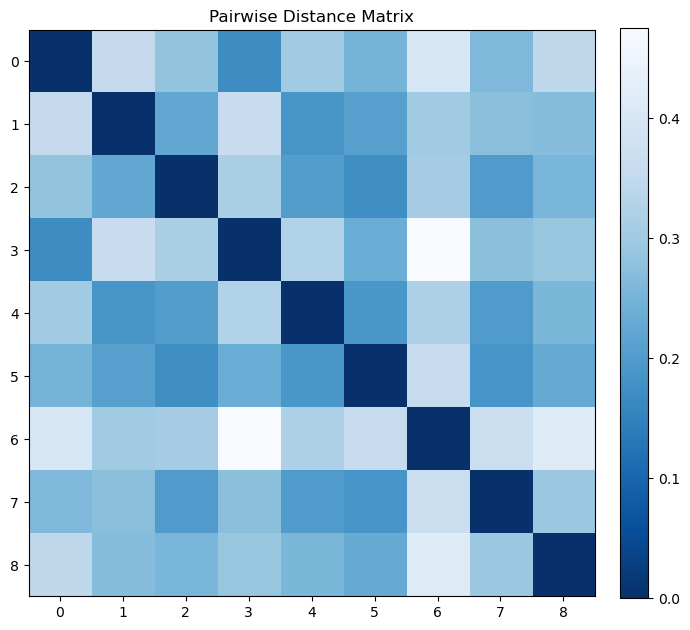

In [111]:
plot_matrix(embeddings_data, labels_data_str)

## Classification with DB

In [ ]:
OBJECTS_ROOT = r"/home/shared/datasets/pollen_dataset_2024_08_14_objects_clean"

In [69]:
def save_class_to_indices(class_to_indices: dict, filename: str):
    with open(filename, 'w') as f:
        json.dump(class_to_indices, f)

def load_class_to_indices(filename):
    with open(filename, 'r') as f:
        return json.load(f)

In [70]:
known_classes = os.listdir(OBJECTS_ROOT)

In [134]:
total_samples = 0
class_to_indices = {c: [] for c in known_classes}
f = 2048  # Length of item vector that will be indexed
db = AnnoyIndex(f, 'euclidean')
for c in tqdm(known_classes):
    images = glob(os.path.join(OBJECTS_ROOT, c, "*.png"))
    print(f"{len(images)} samples in the class {c}")
    
    for idx, img_path in enumerate(tqdm(images)):
        features = extract_features(img_path, loaded_model)
        class_to_indices[c].append(total_samples)
        db.add_item(total_samples, features)
        total_samples += 1

print(f"Total samples: {total_samples}")
db.build(10) # 10 trees

  0%|          | 0/18 [00:00<?, ?it/s]

103 samples in the class Alnus


  0%|          | 0/103 [00:00<?, ?it/s]

205 samples in the class Betula


  0%|          | 0/205 [00:00<?, ?it/s]

146 samples in the class Corylus


  0%|          | 0/146 [00:00<?, ?it/s]

316 samples in the class Acer


  0%|          | 0/316 [00:00<?, ?it/s]

150 samples in the class Chenopodiaceae


  0%|          | 0/150 [00:00<?, ?it/s]

73 samples in the class Pinus


  0%|          | 0/73 [00:00<?, ?it/s]

52 samples in the class Poaceae


  0%|          | 0/52 [00:00<?, ?it/s]

131 samples in the class Apiaceae


  0%|          | 0/131 [00:00<?, ?it/s]

98 samples in the class Rumex


  0%|          | 0/98 [00:00<?, ?it/s]

234 samples in the class Salix


  0%|          | 0/234 [00:00<?, ?it/s]

210 samples in the class Populus tremula


  0%|          | 0/210 [00:00<?, ?it/s]

42 samples in the class Urtica


  0%|          | 0/42 [00:00<?, ?it/s]

242 samples in the class Artemisia


  0%|          | 0/242 [00:00<?, ?it/s]

99 samples in the class Picea


  0%|          | 0/99 [00:00<?, ?it/s]

113 samples in the class Tilia


  0%|          | 0/113 [00:00<?, ?it/s]

113 samples in the class Plantago


  0%|          | 0/113 [00:00<?, ?it/s]

88 samples in the class Quercus


  0%|          | 0/88 [00:00<?, ?it/s]

186 samples in the class Fraxinus


  0%|          | 0/186 [00:00<?, ?it/s]

Total samples: 2601


True

Alnus: 103
Betula: 205
Corylus: 146
Acer: 316
Chenopodiaceae: 150
Pinus: 73
Poaceae: 52
Apiaceae: 131
Rumex: 98
Salix: 234
Populus tremula: 210
Urtica: 42
Artemisia: 242
Picea: 99
Tilia: 113
Plantago: 113
Quercus: 88
Fraxinus: 186


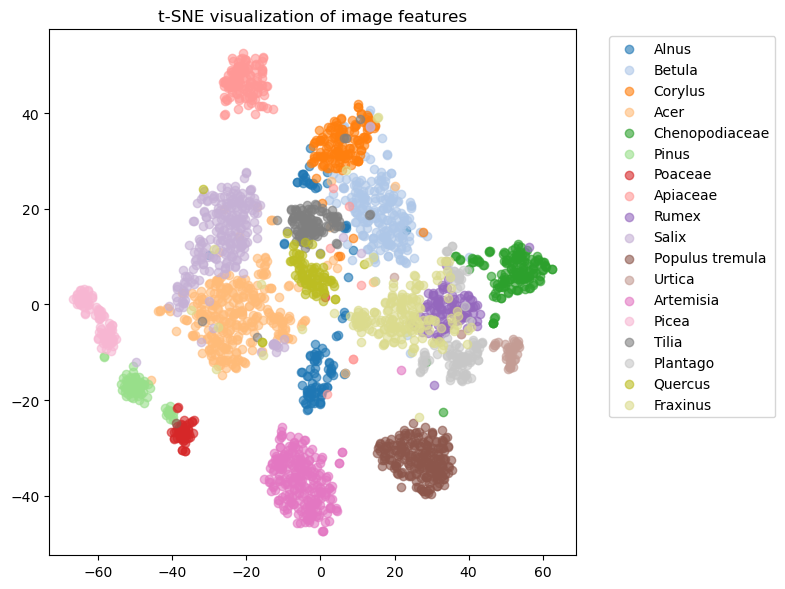

In [137]:
vectors = np.array(list(db.get_item_vector(i) for i in range(db.get_n_items())))
colors = matplotlib.colormaps['tab20'].colors

labels = [""] * vectors.shape[0]
for class_name, indices in class_to_indices.items():
    for index in indices:
        labels[index] = class_name
    print(f"{class_name}: {len(indices)}")

tsne = TSNE(n_components=2, random_state=42)
vectors_2d = tsne.fit_transform(vectors)

plt.figure(figsize=(8, 6))
for i, (class_name, indices) in enumerate(class_to_indices.items()):
    mask = np.isin(range(vectors.shape[0]), indices)
    plt.scatter(vectors_2d[mask, 0], vectors_2d[mask, 1], 
                label=class_name, color=colors[i], alpha=0.6)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE visualization of image features")
plt.tight_layout()
plt.show()

In [158]:
embeddings_data = []
images = glob(os.path.join(input_dir, "*.png"))

for image_path in tqdm(images):
    embeddings_data.append(extract_features(image_path, loaded_model))

  0%|          | 0/9 [00:00<?, ?it/s]

In [155]:
def get_class(db, vector, k=5):
    new_vector = embeddings_data[0]
    neighbor_ids = db.get_nns_by_vector(vector, k, include_distances=False)
    
    index_to_class = {}
    for class_name, indices in class_to_indices.items():
        for index in indices:
            index_to_class[index] = class_name
    
    neighbor_classes = [index_to_class[neighbor_id] for neighbor_id in neighbor_ids]
    most_common_class = Counter(neighbor_classes).most_common(1)[0][0]
    return most_common_class

In [217]:
def plot(imgs, labels):
    num_rows = 1
    num_cols = len(imgs)
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False, figsize=(num_cols * 3, num_rows * 5))
    for col_idx, img in enumerate(imgs):
        ax = axs[0][col_idx]
        img = Image.open(imgs[col_idx])
        ax.imshow(img)
        if ax_title:
            ax.set_title(labels[col_idx])
    plt.show()

In [213]:
pred = []
for image_path in tqdm(images): 
    vector = extract_features(image_path, loaded_model)
    pred.append(get_class(db, vector))

  0%|          | 0/9 [00:00<?, ?it/s]

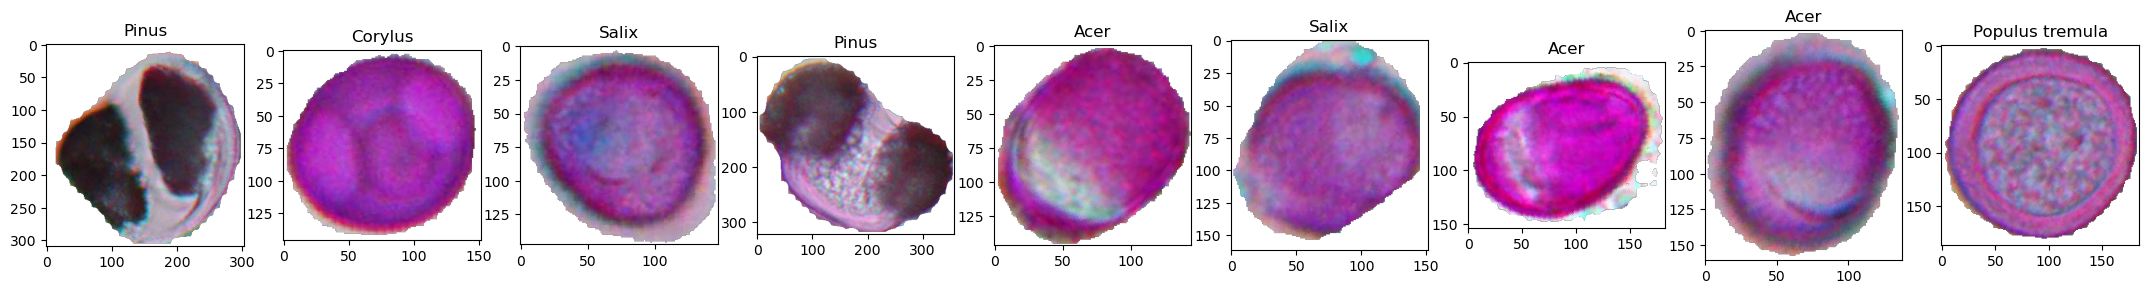

In [218]:
plot(images, pred)